<a href="https://colab.research.google.com/github/dottorm/comic-scraper/blob/main/comic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from zipfile import ZipFile
import os
import shutil
from datetime import date

from google.colab import drive

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
file_name = 'output_'+str(date.today())+'.txt'
csv_path = 'output/'+file_name
drive.mount('/content/gdrive')
output = 'output/'
!mkdir 'dataset'
!mkdir 'output'
!cp '/content/gdrive/My Drive/dataset.zip' 'dataset/dataset.zip'
!cp '/content/gdrive/My Drive/dataset2.zip' 'dataset/dataset2.zip'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘output’: File exists


In [ ]:
with ZipFile("dataset/dataset2.zip", "r") as zipobj:
    zipobj.extractall("dataset")

with ZipFile("dataset/dataset.zip", "r") as zipobj:
    zipobj.extractall("dataset")

data_dir = pathlib.Path('dataset/dataset2')
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

1080


In [ ]:
f = open(csv_path, "w")
f.write('total files : '+str(image_count)+'\r\n')

20

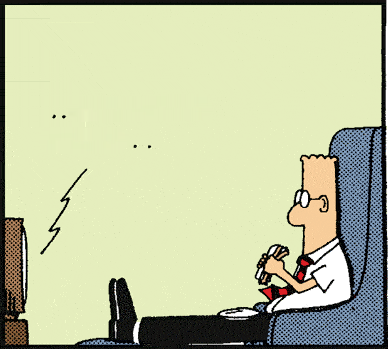

In [ ]:
roses = list(data_dir.glob('dilbert/*'))
PIL.Image.open(str(roses[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1080 files belonging to 53 classes.
Using 864 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1080 files belonging to 53 classes.
Using 216 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['alice', 'alice_catbert', 'alice_tina', 'alice_unknown', 'asok', 'bob_dawn', 'boss', 'boss_alice', 'boss_asok', 'boss_catbert', 'boss_dogbert', 'boss_tina', 'boss_unknown', 'boss_wally', 'buildings', 'catbert', 'catbert_unknown', 'devil', 'dilbert', 'dilbert_alice', 'dilbert_asok', 'dilbert_bob_dawn', 'dilbert_boss', 'dilbert_boss_alice', 'dilbert_boss_asok', 'dilbert_boss_catbert', 'dilbert_boss_tina', 'dilbert_boss_unknown', 'dilbert_boss_wally', 'dilbert_boss_wally_alice', 'dilbert_catbert', 'dilbert_devil', 'dilbert_dogbert', 'dilbert_tina', 'dilbert_unknown', 'dilbert_wally', 'dilbert_wally_alice', 'dogbert', 'dogbert_unknown', 'dogbert_wally', 'house', 'objects', 'ratbert', 'santa', 'tina', 'unknown', 'waiter', 'wally', 'wally_alice', 'wally_asok', 'wally_catbert', 'wally_dogbert', 'wally_unknown']


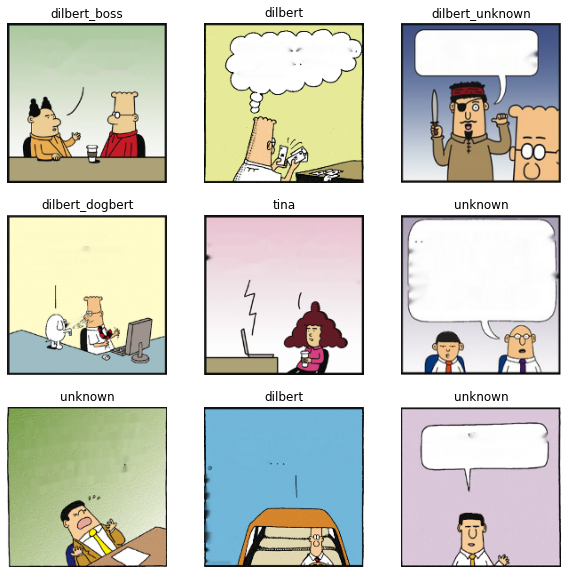

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
27/27 [==============================] - 2s 48ms/step - loss: 3.2809 - accuracy: 0.1389 - val_loss: 2.9795 - val_accuracy: 0.2037
Epoch 2/100
27/27 [==============================] - 1s 24ms/step - loss: 2.8075 - accuracy: 0.2708 - val_loss: 2.7362 - val_accuracy: 0.2454
Epoch 3/100
27/27 [==============================] - 1s 24ms/step - loss: 2.3873 - accuracy: 0.3542 - val_loss: 2.6571 - val_accuracy: 0.3241
Epoch 4/100
27/27 [==============================] - 1s 24ms/step - loss: 1.8850 - accuracy: 0.4711 - val_loss: 2.7491 - val_accuracy: 0.3009
Epoch 5/100
27/27 [==============================] - 1s 24ms/step - loss: 1.4014 - accuracy: 0.5926 - val_loss: 3.1647 - val_accuracy: 0.3194
Epoch 6/100
27/27 [==============================] - 1s 24ms/step - loss: 0.9517 - accuracy: 0.7373 - val_loss: 3.4803 - val_accuracy: 0.3287
Epoch 7/100
27/27 [==============================] - 1s 24ms/step - loss: 0.5703 - accuracy: 0.8160 - val_loss: 4.2567 - val_accuracy: 0.3241
Epoch 

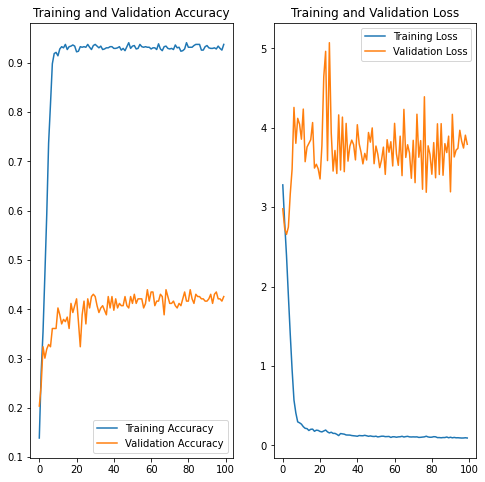

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
f.write('accurancy: '+str(history.history['accuracy'])+'\r\n')
f.write('validation_accurancy: '+str(history.history['val_accuracy'])+'\r\n')

2063

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

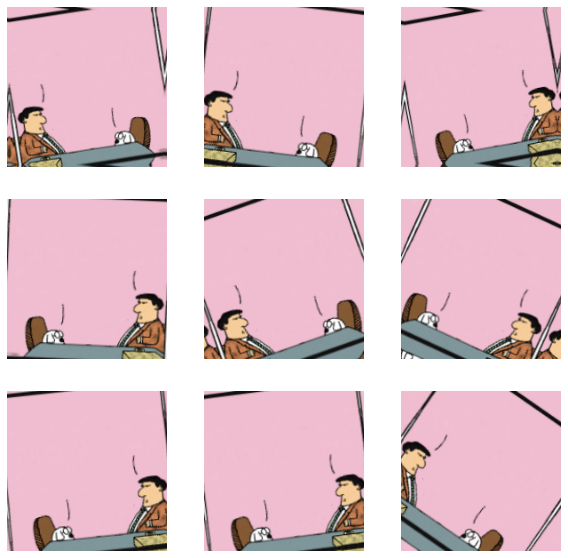

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
27/27 [==============================] - 1s 32ms/step - loss: 0.1322 - accuracy: 0.9259 - val_loss: 3.2543 - val_accuracy: 0.4120
Epoch 2/100
27/27 [==============================] - 1s 24ms/step - loss: 0.1153 - accuracy: 0.9340 - val_loss: 3.8140 - val_accuracy: 0.4167
Epoch 3/100
27/27 [==============================] - 1s 24ms/step - loss: 0.1151 - accuracy: 0.9317 - val_loss: 4.0192 - val_accuracy: 0.4213
Epoch 4/100
27/27 [==============================] - 1s 24ms/step - loss: 0.1278 - accuracy: 0.9282 - val_loss: 4.1925 - val_accuracy: 0.3704
Epoch 5/100
27/27 [==============================] - 1s 24ms/step - loss: 0.1134 - accuracy: 0.9340 - val_loss: 3.8902 - val_accuracy: 0.3935
Epoch 6/100
27/27 [==============================] - 1s 24ms/step - loss: 0.1110 - accuracy: 0.9363 - val_loss: 3.4677 - val_accuracy: 0.4074
Epoch 7/100
27/27 [==============================] - 1s 24ms/step - loss: 0.1074 - accuracy: 0.9363 - val_loss: 3.8408 - val_accuracy: 0.3750
Epoch 

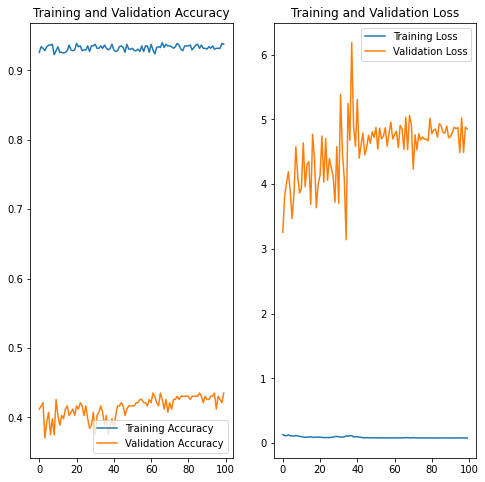

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def create_dir(output):
  if not os.path.exists(output):
    os.mkdir(output)


def prepare_environment(source):

  for name in class_names:
    output = source+name
    create_dir(output)

def move_file(source, permutation,file):

  splitted = permutation.split('_')
  print(splitted)
  for name in splitted:
    for class_name in class_names:
      if name == class_name:
        output = source+name
        print(file)
        print(output)
        shutil.copy(file,output)



In [ ]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('test', origin=)

prepare_environment(output)

f.write('file_name,class_name,confidence\r\n')

def analyze(file):
  img = tf.keras.utils.load_img(file
      , target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  confidence = 100 * np.max(score)
  class_name = class_names[np.argmax(score)]
  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_name, confidence)
  )

  f.write('{},{},{:.2f}\r\n'.format(file,class_name, confidence))

  if confidence < 60.:
    output = 'output/to_check'
    create_dir(output)
    shutil.move(file,output)
  else:
    print(class_name)
    output = 'output/'+class_name
    create_dir(output)
    shutil.copy(file,output)
    #if '_' in class_name:
      #output = 'output/'
      #move_file(output, class_name,file)
    
  
for file in [os.path.join('dataset/dataset', file) for file in os.listdir('dataset/dataset')]:
  analyze(file)

for name in class_names:
  out = output+name
  data_dir = pathlib.Path(out)
  f.write('{}: {}\r\n'.format(name,len(list(data_dir.glob('*.png')))))
  f.write('{}: {}\r\n'.format('to_check',len(list(pathlib.Path('output/to_check').glob('*.png')))))

f.close()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
This image most likely belongs to dilbert_boss with a 89.47 percent confidence.
dilbert_boss
1/1 [==============================] - 0s 21ms/step
This image most likely belongs to boss with a 90.48 percent confidence.
boss
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to devil with a 58.13 percent confidence.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to dilbert with a 100.00 percent confidence.
dilbert
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to dilbert_boss with a 70.57 percent confidence.
dilbert_boss
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to dilbert with a 99.50 percent confidence.
dilbert
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to dilbert_boss with a 100.00 percent confidence.
d

In [ ]:
shutil.copy(csv_path, '/content/gdrive/My Drive/')

'/content/gdrive/My Drive/output_2023-01-29.txt'

In [ ]:
#!cp -r 'output/to_check' '/content/gdrive/My Drive/to_check'
#!cp csv csv_path '/content/gdrive/My Drive/to_check'

In [ ]:
!ls 'output/to_check' | wc -l

In [ ]:
#!rm -rf 'output'
#!mkdir 'output'

In [ ]:
#!rm -rf 'output'
#!rm -rf 'dataset'